In [50]:
import matplotlib.pyplot as plt
from scipy import stats
# import random
import numpy as np
import ray
from ray.rllib.agents import ppo, a3c, dqn, sac
import torch

from mdps.cattle import cMDPCattle
from utils.distributions import ConstantDistribution, ParticleDistribution, UniformDistribution

In [2]:
def get_rollouts(solver_, config):
    """Generate rollouts from a given solver and MDP(c)"""
    env_ = cMDPCattle(config=config)
    done_ = False
    obs_ = env_.reset()
    # run until episode ends
    gt_obs_arr_ = obs_
    gt_act_arr_ = None
    gt_rew_arr_ = None
    while not done_:
        action_ = solver_.compute_single_action(obs_)
        obs_, rewawrd_, done_, _ = env_.step(action_)
        gt_obs_arr_ = np.vstack((gt_obs_arr_, obs_))
        if gt_act_arr_ is None:
            gt_act_arr_ = [action_]
            gt_rew_arr_ = [rewawrd_]
        else:
            gt_act_arr_ += [action_]
            gt_rew_arr_ += [rewawrd_]

    gt_act_arr_ = np.array(gt_act_arr_)
    gt_rew_arr_ = np.array(gt_rew_arr_)
    return gt_obs_arr_[1:,:], gt_act_arr_, gt_rew_arr_

def plot_rollouts(gt_obs_arr_, gt_act_arr_):
    """Plot generated rollouts"""
    fig_, ax_1 = plt.subplots()
    fig_.set_size_inches(10, 6, forward=True)

    x = np.arange(start=0, stop=gt_obs_arr_.shape[0])
    ax_2 = ax_1.twinx()
    ax_1.plot(x, gt_obs_arr_[:,2], 'r-')
    ax_2.plot(x, gt_act_arr_, 'b-', alpha=0.3)

    ax_1.set_xlabel('time step')
    ax_1.set_ylabel('Breeding Stock(x)', color='r')
    ax_2.set_ylabel('Action', color='b')
    plt.title('sample observations and actions')
    plt.show()

In [3]:
c = {"context_distribution":
        ConstantDistribution(dim=10, constant_vector=np.array([1.0, 1.4, 0.95, 0.93, 0.7, .53, .40, 1E-8, 3.7, 6.3]))
    }

### 1. PPO

In [4]:
'''
np.random.seed(1111)
random.seed(1111)
torch.manual_seed(1111)
'''
ray.shutdown()
ray.init()

expert = ppo.PPOTrainer(env=cMDPCattle, config={
    "env_config": c,
    "framework": "torch",  # config to pass to env class
})

rews = []
for eps in range(40):
    res = expert.train()
    if eps % 5 == 0:
        print(eps, res['episode_reward_mean'])
    rews += [res['episode_reward_mean']]

2022-04-30 15:10:41,117	INFO ppo.py:166 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-04-30 15:10:41,118	INFO trainer.py:743 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2022-04-30 15:10:43,335	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2022-04-30 15:10:52,942	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 488837437.0x the scale of `vf_clip_param`. This means that it will take more than 488837437.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.


0 -4888374367.165808


2022-04-30 15:11:02,401	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 279039679.0x the scale of `vf_clip_param`. This means that it will take more than 279039679.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-30 15:11:11,704	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 135064795.0x the scale of `vf_clip_param`. This means that it will take more than 135064795.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-30 15:11:21,071	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 9421724.0x the scale of `vf_clip_param`. This means that it will take more than 9421724.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-30 15:11:30,554	WARNING ppo.py:245 -- The magnitude of your environment reward

5 -6737950.9681786345


2022-04-30 15:11:49,217	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 170549.0x the scale of `vf_clip_param`. This means that it will take more than 170549.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-30 15:11:58,486	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 137597.0x the scale of `vf_clip_param`. This means that it will take more than 137597.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-30 15:12:07,819	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 97415.0x the scale of `vf_clip_param`. This means that it will take more than 97415.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-30 15:12:17,038	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 

10 -829916.9681508617


2022-04-30 15:12:35,783	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 48469.0x the scale of `vf_clip_param`. This means that it will take more than 48469.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-30 15:12:45,087	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 51291.0x the scale of `vf_clip_param`. This means that it will take more than 51291.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-30 15:12:54,441	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 49829.0x the scale of `vf_clip_param`. This means that it will take more than 49829.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-30 15:13:03,699	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 6075

15 -655892.6638544871


2022-04-30 15:13:22,122	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 59547.0x the scale of `vf_clip_param`. This means that it will take more than 59547.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-30 15:13:31,412	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 53779.0x the scale of `vf_clip_param`. This means that it will take more than 53779.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-30 15:13:40,687	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 43076.0x the scale of `vf_clip_param`. This means that it will take more than 43076.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-30 15:13:49,964	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 3463

20 -292491.4446918296


2022-04-30 15:14:08,594	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 31094.0x the scale of `vf_clip_param`. This means that it will take more than 31094.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-30 15:14:17,834	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 26976.0x the scale of `vf_clip_param`. This means that it will take more than 26976.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-30 15:14:27,014	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 30438.0x the scale of `vf_clip_param`. This means that it will take more than 30438.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-30 15:14:36,158	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 2159

25 -137084.0188750876


2022-04-30 15:14:54,678	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 11451.0x the scale of `vf_clip_param`. This means that it will take more than 11451.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-30 15:15:03,956	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 10531.0x the scale of `vf_clip_param`. This means that it will take more than 10531.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-30 15:15:13,225	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 6428.0x the scale of `vf_clip_param`. This means that it will take more than 6428.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-30 15:15:22,447	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 6871.0

30 -46581.00590144463


2022-04-30 15:15:40,783	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 4281.0x the scale of `vf_clip_param`. This means that it will take more than 4281.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-30 15:15:49,914	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 3402.0x the scale of `vf_clip_param`. This means that it will take more than 3402.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-30 15:15:59,315	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 2431.0x the scale of `vf_clip_param`. This means that it will take more than 2431.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-30 15:16:08,639	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 1859.0x th

35 -1054.5150447392587


2022-04-30 15:16:27,138	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 2403.0x the scale of `vf_clip_param`. This means that it will take more than 2403.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-30 15:16:36,462	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 1564.0x the scale of `vf_clip_param`. This means that it will take more than 1564.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-30 15:16:45,779	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 3023.0x the scale of `vf_clip_param`. This means that it will take more than 3023.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-30 15:16:54,972	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 2497.0x th

### 2. A3C

In [5]:
ray.shutdown()
ray.init()

expert_a3c = a3c.A3CTrainer(env=cMDPCattle, config={
    "env_config": c,
    "framework": "torch",  # config to pass to env class
})

rews = []
for eps in range(40):
    res = expert_a3c.train()
    if eps % 5 == 0:
        print(eps, res['episode_reward_mean'])
    rews += [res['episode_reward_mean']]

2022-04-19 20:21:12,925	WARNING deprecation.py:45 -- DeprecationWarning: `convert_to_non_torch_type` has been deprecated. Use `ray/rllib/utils/numpy.py::convert_to_numpy` instead. This will raise an error in the future!
2022-04-19 20:21:12,932	WARNING util.py:57 -- Install gputil for GPU system monitoring.
 pid=28452) 2022-04-19 20:21:12,907	WARNING deprecation.py:45 -- DeprecationWarning: `convert_to_non_torch_type` has been deprecated. Use `ray/rllib/utils/numpy.py::convert_to_numpy` instead. This will raise an error in the future!


0 nan
5 3890.596823453836
10 -22662171.94710267
15 -1123231.7957704666
20 -41864861.398907304
25 -13949.008712648072
30 -6254.112748540089
35 1853.423522268869


### 3. DQN

In [6]:
ray.shutdown()
ray.init()

expert_dqn = dqn.DQNTrainer(env=cMDPCattle, config={
    "env_config": c,
    "framework": "torch",  # config to pass to env class
})

rews = []
for eps in range(40):
    res = expert_dqn.train()
    if eps % 5 == 0:
        print(eps, res['episode_reward_mean'])
    rews += [res['episode_reward_mean']]

2022-04-19 20:24:39,333	WARNING util.py:57 -- Install gputil for GPU system monitoring.


0 -4295512492.092217
5 -748774287.2661394
10 -19719694.793346412
15 -3973.6409350262884
20 4666.274261989991
25 3653.069127250357
30 3152.224775306542
35 3245.254321484114


### 4. SAC

In [75]:
ray.shutdown()
ray.init()

expert_sac = sac.SACTrainer(env=cMDPCattle, config={
    "env_config": c,
    "framework": "torch",  # config to pass to env class
})

rews = []
for eps in range(40):
    res = expert_sac.train()
    if eps % 5 == 0:
        print(eps, res['episode_reward_mean'])
    rews += [res['episode_reward_mean']]

2022-04-19 20:45:46,332	WARNING util.py:57 -- Install gputil for GPU system monitoring.


0 -51387105657184.13
5 -38540329242718.45
10 -30832263393030.95
15 -25693552826739.07
20 -22023045279667.957
25 -19270164619186.324
30 -17129035217065.803
35 -15416131694972.314


### 5. Random

In [55]:
ray.shutdown()
ray.init()

expert_rdm = ppo.PPOTrainer(env=cMDPCattle, config={
    "env_config": c,
    "framework": "torch",  # config to pass to env class
})

2022-04-19 20:37:22,462	WARNING util.py:57 -- Install gputil for GPU system monitoring.


---

In [90]:
r = np.zeros(500)
for i in range(500):
    gt_obs_arr, gt_act_arr, gt_rew_arr = get_rollouts(expert_a3c, config=c)
    r[i] = sum(gt_rew_arr)
print(np.mean(r))

-4573.732243197607


In [88]:
gt_obs_arr, gt_act_arr, gt_rew_arr = get_rollouts(expert_a3c, config=c)

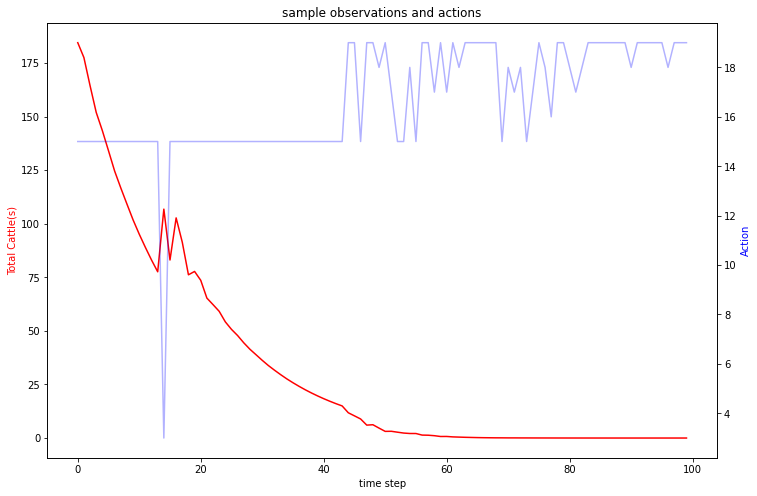

In [92]:
fig_, ax_1 = plt.subplots()
fig_.set_size_inches(12, 8, forward=True)

x = np.arange(start=0, stop=gt_obs_arr.shape[0])
ax_2 = ax_1.twinx()
ax_1.plot(x, gt_obs_arr[:,2], 'r-')
ax_2.plot(x, gt_act_arr, 'b-', alpha=0.3)

ax_1.set_xlabel('time step')
ax_1.set_ylabel('Total Cattle(s)', color='r')
ax_2.set_ylabel('Action', color='b')
plt.title('sample observations and actions')
# plt.savefig('cattle_a3c.pdf')
plt.show()

---

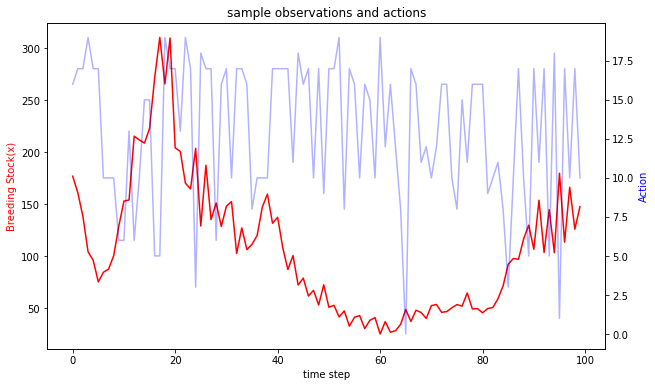

In [30]:
gt_obs_arr, gt_act_arr, gt_rew_arr = get_rollouts(expert, config=c)
plot_rollouts(gt_obs_arr, gt_act_arr)

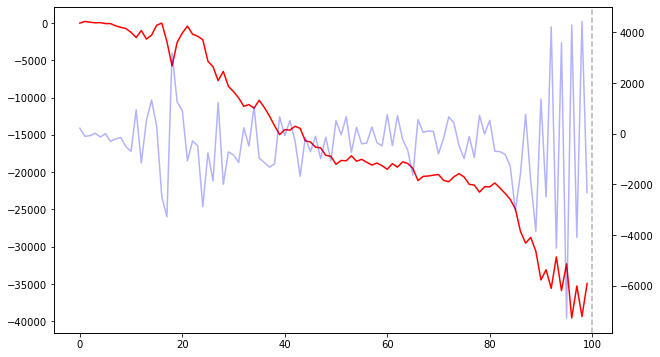

In [31]:
rew = np.zeros(gt_rew_arr.shape[0])
for i in range(rew.shape[0]):
    rew[i] = sum(gt_rew_arr[:i])

fig, ax_1 = plt.subplots()
fig.set_size_inches(10, 6, forward=True)

x = np.arange(start=0, stop=gt_rew_arr.shape[0])
ax_2 = ax_1.twinx()
ax_1.plot(x, rew, 'r-')
ax_2.plot(x, gt_rew_arr, 'b-', alpha=0.3)
plt.axvline(x=100, alpha=0.3, color='black', linestyle='--')

In [93]:
N = 1000000
T = 100

def posterior_sample_params(action=gt_act_arr, reward=gt_rew_arr, N=N, obs=gt_obs_arr,):

    gamma_0 = 1.0
    gamma_1 = np.random.normal(loc=0.5,scale=1.,size=N)
    g = 0.95
    rho_h = 0.93
    rho_m = 0.7
    sigma_h = 0.53
    sigma_m = 0.4
    espilon_sq = 1E-8
    mu_h = 3.7
    mu_m = 6.3

    x_pp = obs[:,0]
    x_p = obs[:,1]
    k = obs[:,2]
    m = obs[:,3]
    h = obs[:,4]
    p = obs[:,5]

    c = action.reshape(-1)*k/19
    r = reward.reshape(-1)

    for t in range(T-1):
        # evaluate probability of particles
        h_t = (((p[t] - m[t]) * c[t] - r[t]
                - espilon_sq * (x[t] ** 2 + x_p[t] ** 2 + x_pp[t] ** 2 + c[t] ** 2))
                / (x[t] + gamma_0 * g * x_p[t] + gamma_1 * g * x_pp[t]))

        eps_p = p[t+1] - 2.5 - p[t]
        eps_m = m[t+1] - (1 - rho_m) * mu_m - m[t]
        eps_h = h[t+1] - (1 - rho_h) * mu_h - h_t
        # eps_h = h[t+1] - (1 - rho_h) * mu_h - h[t]

        likelihood_p = stats.norm.pdf(eps_p, loc=0, scale=4)
        likelihood_m = stats.norm.pdf(eps_m, loc=0, scale=sigma_m)
        likelihood_h = stats.norm.pdf(eps_h, loc=0, scale=sigma_h)
        q = likelihood_p * likelihood_m * likelihood_h
        q = np.nan_to_num(q, copy=False)
        
        if q.sum() == 0.0:
            continue

        # resample particles according to probability
        resample_index = np.random.choice(np.arange(N), N, p=q/q.sum())
        gamma_1 = gamma_1[resample_index]
        gamma_1_noise = np.random.normal(loc=0, scale=gamma_1.std(), size=gamma_1.shape) * 0.2
        gamma_1 += gamma_1_noise
        
        
        if t % 25 == 0:
            print("round", t, "posterior mean", gamma_1.mean())

    return gamma_1

In [94]:
prior = np.random.normal(loc=0.5,scale=1.,size=N)

gamma_1_post = posterior_sample_params()

round 0 posterior mean 2.4279810660576855
round 25 posterior mean 3.522319388221595
round 50 posterior mean 3.673422561760669
round 75 posterior mean 3.583068847907724


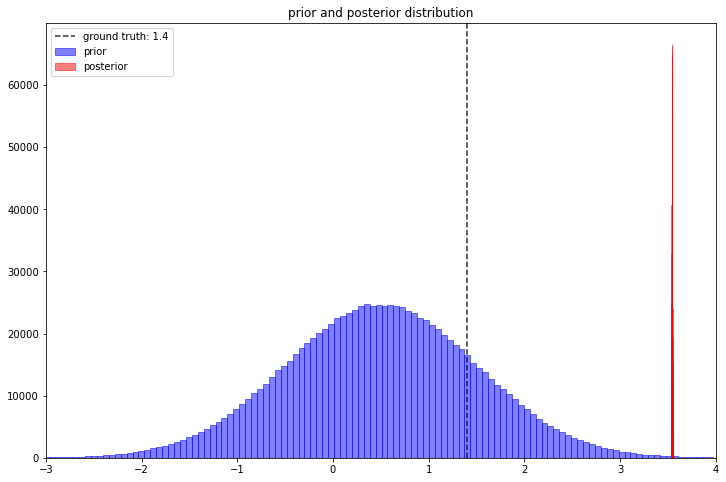

(pid=None) [2022-04-30 16:01:00,948 C 49532 79284] redis_client.cc:87:  Check failed: under_retry_limit Expected 1 Redis shard addresses, found 8104303535147543913
(pid=None) *** StackTrace Information ***
(pid=None)     recalloc
(pid=None)     BaseThreadInitThunk
(pid=None)     RtlUserThreadStart
(pid=None) 
(pid=None) [2022-04-30 16:01:07,057 E 73904 74440] local_object_manager.cc:32: Plasma object ffffffffffffffffffffffffffffffffffffffff0100000001000000 was evicted before the raylet could pin it.
(pid=None) [2022-04-30 16:01:07,065 C 73904 74440] local_object_manager.cc:88:  Check failed: (pinned_objects_.count(object_id) > 0) || (spilled_objects_url_.count(object_id) > 0) || (objects_pending_spill_.count(object_id) > 0) 
(pid=None) *** StackTrace Information ***
(pid=None)     BaseThreadInitThunk
(pid=None)     RtlUserThreadStart
(pid=None) 
2022-04-30 16:01:36,083	WARNING worker.py:1245 -- The node with node id: 28471172be18d733639ff783fd7fbc85083f0cd6847d781395fc8054 and ip: 127.

In [96]:
fig, ax = plt.subplots()
ax.hist(prior, bins=150, lw=1,
         ec="blue", fc="blue", alpha=0.5)
ax.hist(gamma_1_post, bins=50, lw=1,
         ec="red", fc="red", alpha=0.5)
plt.xlim((-3,4))
plt.axvline(x=1.4, alpha=0.8, color='black', linestyle='--')
plt.legend(["ground truth: 1.4", "prior", "posterior"])
fig.set_size_inches(12, 8)
plt.title('prior and posterior distribution')
plt.show()
# plt.savefig("cattle_est_gamma_1.pdf")

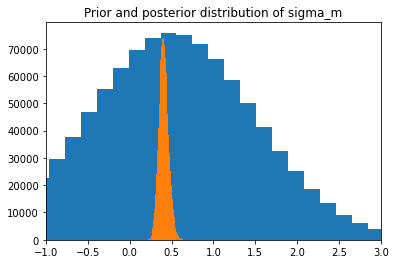

In [78]:
plt.hist(prior, bins=50)
plt.hist(sigma_m_post, bins=50)
plt.xlim((-1,3))
plt.title('Prior and posterior distribution of sigma_m')
plt.show()

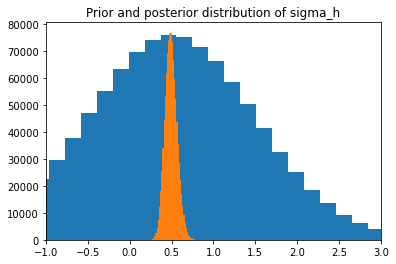

In [79]:
plt.hist(prior, bins=50)
plt.hist(sigma_h_post, bins=50)
plt.xlim((-1,3))
plt.title('Prior and posterior distribution of sigma_h')
plt.show()

In [77]:
print(rho_h_post.mean())
print(rho_m_post.mean())
print(sigma_h_post.mean())
print(sigma_m_post.mean())

0.8976940822837548
0.6946162294294301
0.4933960295167706
0.40608041551356927


In [114]:
# Filter function
def filter_context(solver_,
                   context_distribution_,
                   gt_obs_arr_,
                   T_,
                   N_
                   ):
    state_arr_ = np.ones((N_,7))
    action_arr_ = np.zeros((N_,))
    context_history_ = []
    for t_ in range(T_):
        # we only use the first 5 steps of the cartpole steps to reduce effect of different episode lengths
        qs_ = np.zeros((N_,))
        for n_ in range(N_):
            context_ = context_distribution_.particles[n_]
            c_local_ = {"context_distribution":
                           ConstantDistribution(dim=10,
                                                constant_vector=context_)
            }
            env_ = cMDPCattle(config=c_local_)
            obs_ = env_.reset()
            if t_ > 0:
                env_.mdp.state = state_arr_[n_]
                obs_ = np.concatenate((np.array(env_.mdp.state), context_), axis=0).flatten()
            action_ = solver_.compute_single_action(obs_)
            obs_, reward_, _, _ = env_.step(action_)
            # estimate likelihood if r >= 1
            action_arr_[n_] = action_
            q = env_.likelihood(gt_obs_arr_[t_], action_arr_[n_], obs_, reward_)
            qs_[n_] = q
            state_arr_[n_] = np.copy(env_.mdp.state)
        if t_ >= 1:
            # truncated importance sampling; [https://arxiv.org/pdf/1905.09800.pdf]
            qs_ = np.clip(qs_, 0, np.percentile(qs_, 90))
            if qs_.sum() == 0:
                continue
            qs_ = qs_ / qs_.sum()
            resample_index_ = context_distribution_.resample_particles_from_probability(p=qs_)
            p_temp_ = context_distribution_.particles
            p_noise_ = np.random.normal(loc=0, scale=p_temp_.std(axis=0), size=p_temp_.shape) * 0.3
            context_distribution_.particles += p_noise_
            context_distribution_.particles = np.clip(context_distribution_.particles, 0.0, 10.0)
            state_arr_ = state_arr_[resample_index_]
            action_arr_ = action_arr_[resample_index_]
        if t_ % 25 == 0:
            print("round", t_, "posterior mean", context_distribution_.particles[:, 1].mean())
        context_history_ += [context_distribution_.particles.copy()]
    return context_history_, context_distribution_

In [115]:
# Pre-determined params
N = 1000
T = 100

gamma_0 = np.ones((N,)) * 1.0
# gamma_1 = np.ones((N,)) * 1.4
gamma_1 = np.random.uniform(1.0, 2.0, size=(N,))
g = np.ones((N,)) * 0.95
rho_h = np.ones((N,)) * 0.93
# rho_h = np.random.uniform(0.5, 1.1, size=(N,))
rho_m = np.ones((N,)) * 0.7
# rho_m = np.random.uniform(0.4, 0.8, size=(N,))
sigma_h = np.ones((N,)) * 0.53
# sigma_h = np.random.uniform(0.0, 0.8, size=(N,))
sigma_m = np.ones((N,)) * 0.4
# sigma_m = np.random.uniform(0.0, 0.6, size=(N,))
espilon_sq = np.ones((N,)) * 1E-8
mu_h = np.ones((N,)) * 3.7
mu_m = np.ones((N,)) * 6.3

context_particles = np.abs(np.vstack((gamma_0, gamma_1, g, rho_h, rho_m, sigma_h, sigma_m, espilon_sq, mu_h, mu_m)).T)
context_distribution = ParticleDistribution(dim=10, particles=context_particles, n_particles=N)

In [116]:
c = {"context_distribution":
        ConstantDistribution(dim=10, constant_vector=np.array([1.0, 1.4, 0.95, 0.93, 0.7, .53, .40, 1E-8, 3.7, 6.3]))
    }

In [117]:
context_history_exact, _ = filter_context(expert,
                                          context_distribution,
                                          gt_obs_arr,
                                          T,
                                          N
                                          )

round 0 posterior mean 1.4919708257191395
round 25 posterior mean 1.7904317440968003
round 50 posterior mean 2.1541122001464537
round 75 posterior mean 2.2024827688573825


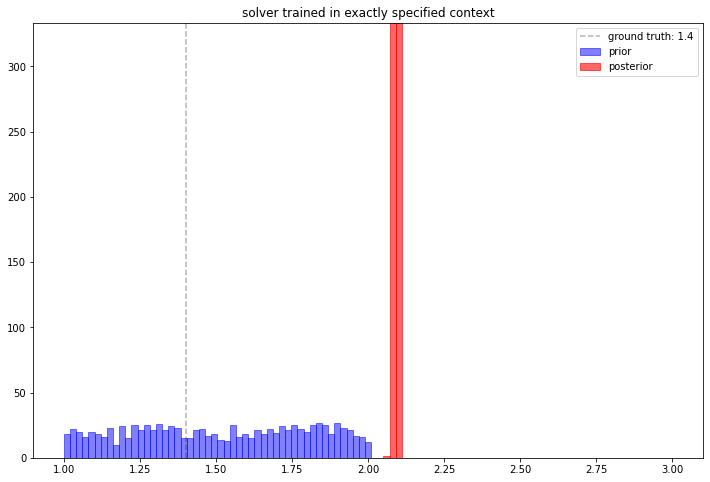

In [113]:
# Plot
fig, ax = plt.subplots()
HIST_BINS = np.linspace(1.0, 3.0, 100)
ax.hist(context_history_exact[0][:, 1], HIST_BINS, lw=1,
        ec="blue", fc="blue", alpha=0.5)
ax.hist(context_history_exact[-1][:, 1], HIST_BINS, lw=1,
        ec="red", fc="red", alpha=0.6)
plt.axvline(x=1.4, alpha=0.3, color='black', linestyle='--')
plt.legend(['ground truth: 1.4', 'prior', 'posterior'])
ax.set_ylim(top=N / 3)
fig.set_size_inches(12, 8)
plt.title('solver trained in exactly specified context')
plt.show()

In [ ]:
'''
p = np.zeros(100)
p[0] = 500
m = np.zeros(100)
m[0] = 350
h = np.zeros(100)
h[0] = 50
for i in range(100-1):
    p[i+1] = p[i] + 25 + np.random.normal(0, 4, 1)[0]
    m[i+1] = m[i] + 0.3*63 + np.random.normal(0, 4, 1)[0]
    h[i+1] = h[i] + 0.07*37 + np.random.normal(0, 5.3, 1)[0]

fig, ax = plt.subplots()
fig.set_size_inches(10, 6, forward=True)

x = np.arange(start=0, stop=100)
ax.plot(x, p, 'r-')
ax.plot(x, m, 'b-', alpha=0.3)
ax.plot(x, h, 'g-')
ax.plot(x, p-m-2.2*h, 'y-')
ax.axhline(y=0.0, alpha=0.3, color='black', linestyle='--')
'''